In [1]:
!pip install transformers datasets accelerate -q
!pip install wandb -q
# -q : 설치과정의 출력 최소화
# !pip install transformers datasets accelerate -q -> pip로 transformers, datasets, accelrate 다운로드
# !pip install wandb -q# wandb -> weight and biases 라이브러리 -> ML 시각화, 추적에 활용됨

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 

# 텍스트 분류

네이버 영화 리뷰 감성 분류: Naver sentiment movie corpus (NSMC)

데이터셋
- train: 150K
- test: 50K

In [2]:
# these are useful libraries, modules for training NLP tasks
import torch
from datasets import load_dataset# hugging face datasets library에서 load_dataset 함수 가져옴 -> 다양한 NLP dataset을 쉽게 로드할 수 있게 해줌
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, pipeline
# AutoConfig : pretrained된 model의 설정 load
# AutoTokenizer :  pretrained된 model에 맞는 tokenizer load
# AutoModelForSequenceClassification :  pretrained된 model을 sequence classification task에 맞게끔 load
# DataCollatorWithPadding : (Collector아님) -> input sequence length를 맞춰주는 역할
# pipeline : 특정 작업을 위한 model, preprocessing, postprocessing과정을 하나로 묶어주는 역할
from transformers import Trainer, TrainingArguments
# Trainer : hugging face transformers 라이브러리에서 필요한 모델 훈련을 위한 고수준 API제공
# TrainingArguments : 훈련 설정 지정
from torch.utils.data import DataLoader
# pytorch에서 data를 batch단위로 model에 공급하기 위해 DataLoader class를 가져옴
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# accuracy_score : for 정확도 , 그 뒤에것도 저런 metric들 가져온다는 말
import numpy as np
import os# for 운영체제 관련 기능
import gc# for garbage collector
from tqdm.notebook import trange, tqdm

In [3]:
dataset_id = "e9t/nsmc"# 허깅페이스 데이터셋에서 e9t/nsmc라는 데이터셋이 있는데 이건 네이버 영화 감성 분류 데이터셋임
# korean text classification task에서 주로 쓰임
model_id = "klue/roberta-small"# klue roberta-small도 한국어 NLP에 적합하게끔 훈련된 모델임

# 데이터셋 로드

In [4]:
ds = load_dataset(dataset_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
print(ds)
print(type(ds))
print(ds.shape)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})
<class 'datasets.dataset_dict.DatasetDict'>
{'train': (150000, 3), 'test': (50000, 3)}


# 토크나이저 설정

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_id)# 저 모델 id에서 pretrained 된 tokenizer를 가져온다는말

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/752k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

토크나이징 함수 정의

In [8]:
def tokenize_function(examples):
    return tokenizer(examples["document"], truncation=True, padding=True)
    # truncation=True : text길이를 모델의 최대 입력길이에 맞게 자름
    # padding = True : 모든 샘플의 length 동일

데이터셋에 토크나이징 적용

In [11]:
tokenized_datasets = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [14]:
print(tokenized_datasets)
print(tokenizer)
print(ds)
# 이게 찍어보면 tokenized_datasets의 feature에 input_ids, token_type_ids, attention_mask가 추가로 더 들어가는걸 볼 수 있는데,
# map(적용시킬 함수, 적용할 값들) 로 쓰이니까.. 가 아니고 datasets 라이브러리의 map함수가 따로 있나봐
# 그래서 그거랑 딱히 상관없고, tokenizer를 통해 text가 토큰화 되는데 , 토큰화 되는 과정에서 추가적인 정보가 생기고 그 정보들을
# 저 셋(input_ids, token_ids, attention_mask)로 새로운 칼럼으로 만들어 데이터셋에 추가되는거같아


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})
BertTokenizerFast(name_or_path='klue/roberta-small', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, spe

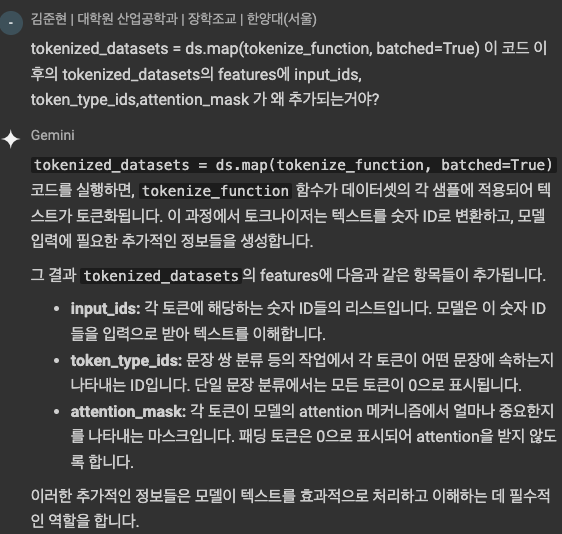

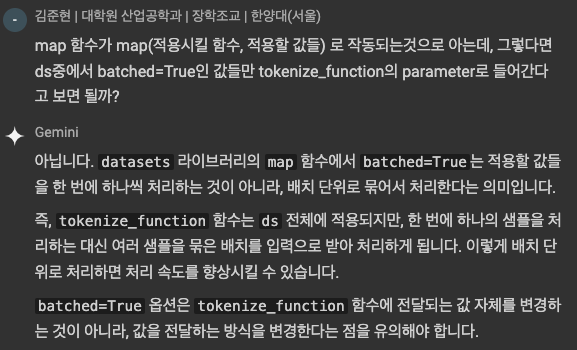
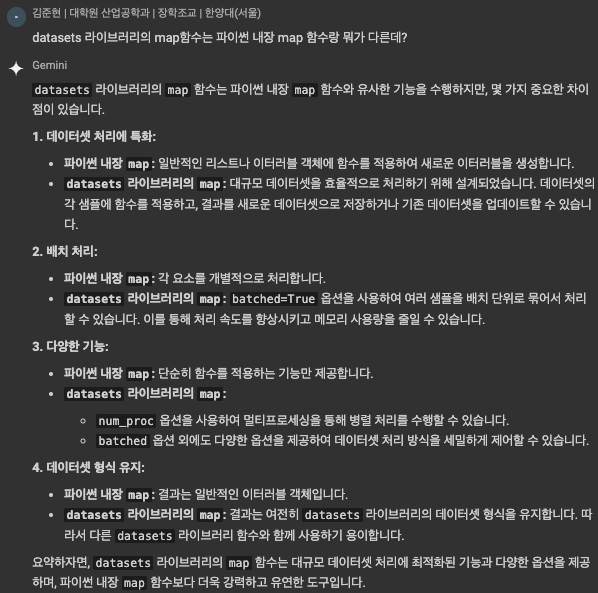

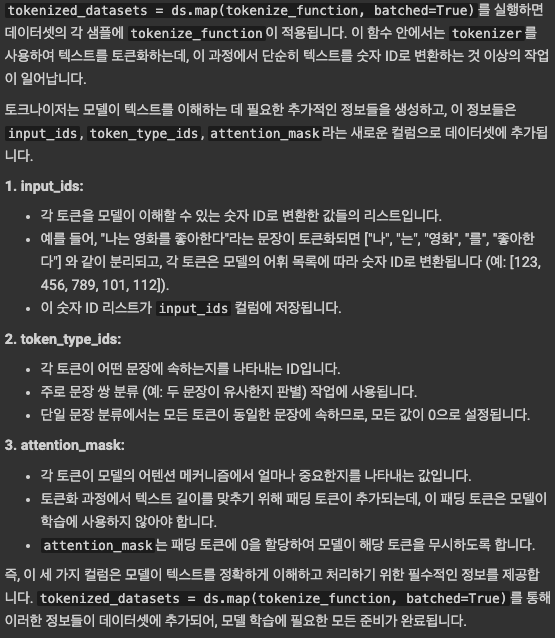  
더 쉽게 이해하기 위해 예시를 들어보겠습니다. "나는 영화를 좋아합니다."라는 문장이 있다고 가정해 봅시다. tokenize_function을 적용하면 다음과 같은 결과가 나올 수 있습니다.

input_ids: [101, 200, 300, 400, 500, 102] (각 숫자는 토큰에 해당하는 ID)
token_type_ids: [0, 0, 0, 0, 0, 0] (모든 토큰이 단일 문장에 속함)
attention_mask: [1, 1, 1, 1, 1, 1] (모든 토큰이 중요함)
이처럼 tokenize_function은 텍스트를 모델이 이해할 수 있는 형태로 변환하고, 모델이 텍스트의 의미를 파악하는 데 필요한 추가적인 정보들을 제공합니다.  

input_ids, token_type_ids, attention_mask -> 이 이름들은 hugging face transformers 라이브러리 내부에서 자동으로 지정되는거래. 그래서 따로 내가 지정할 필요는 없대. 임의로 지정하면 hugging face에서 지정한거랑 충돌이 일어날 수 있어서 안된다려나 뭐라나~

구글 코랩 T4에서 실습시 오래 걸리기 때문에 상위 10%씩의 데이터만 사용

In [15]:
# print(type(tokenized_datasets['train']))

<class 'datasets.arrow_dataset.Dataset'>


In [17]:
tokenized_datasets['train'] = tokenized_datasets['train'].select(range(len(tokenized_datasets['train'])//10))
tokenized_datasets['test'] = tokenized_datasets['test'].select(range(len(tokenized_datasets['test']) // 10))
# datasets.arrow_dataset.Dataset 클래스에서 select문의 역할은  데이터셋에서 특정 인덱스에 해당하는 샘플들을 선택하여 새로운 데이터셋을 생성하는 역할
# ex) dataset.select([0,2,4]) -> index 0th, 2nd , 4th에 해당하는 sample만 select해서 새로운 dataset만듬

# DataCollator 설정

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

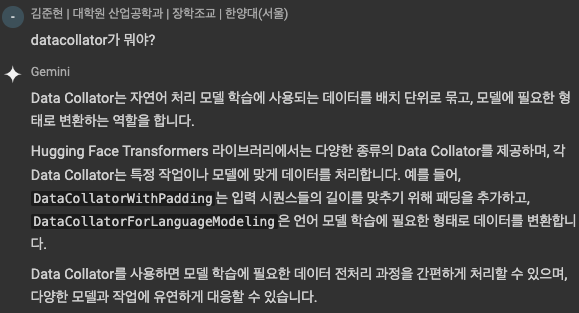

## 확인

In [19]:
ts = tokenized_datasets['train']
print(ts.features)

{'id': Value(dtype='string', id=None), 'document': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive'], id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}


In [20]:
samples = [{k: ts[i][k] for k in ts.features if k in ['input_ids', 'token_type_ids', 'attention_mask', 'label']} for i in range(4)]

In [ ]:
# above code could be changed to this code
samples = []
for i in range(4):
    sample = {}
    for k in ts.features:
        if k in ['input_ids', 'token_type_ids', 'attention_mask', 'label']:
            sample[k] = ts[i][k]
    samples.append(sample)

In [21]:
# DataCollator 적용
batch = data_collator(samples)

In [22]:
print(batch)

{'input_ids': tensor([[    0,  1376,   831,  2604,    18,    18,  4229,  9801,  2075,  2203,
          2182,  4243,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1],
        [    0,  1963,    18,    18,    18, 11811,  2178,  2088, 28883, 16516,
          2776,    18,    18,    18,    18, 10737,  2156,  2015,  2446, 

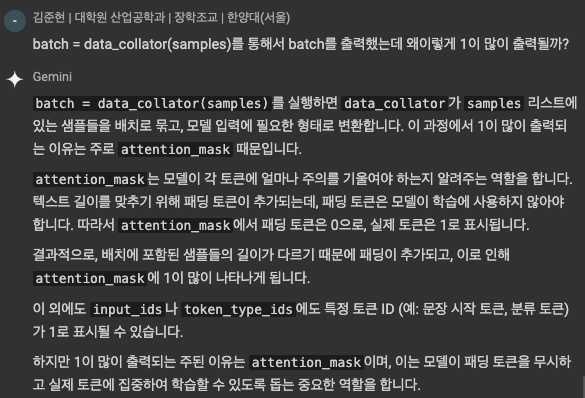  
attention_mask에서 padding token은 0, 실제 token은 1로 표시됨  

# 모델 로드

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

커스텀 레이블 추가

In [24]:
# 레이블 정의
id2label = {0: "부정", 1: "긍정"}
label2id = {"부정": 0, "긍정": 1}

# 설정 로드 및 레이블 지정
config = AutoConfig.from_pretrained(model_id,
                                    num_labels=2,
                                    id2label=id2label,
                                    label2id=label2id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, config=config)

model.safetensors:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 평가 메트릭 정의

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

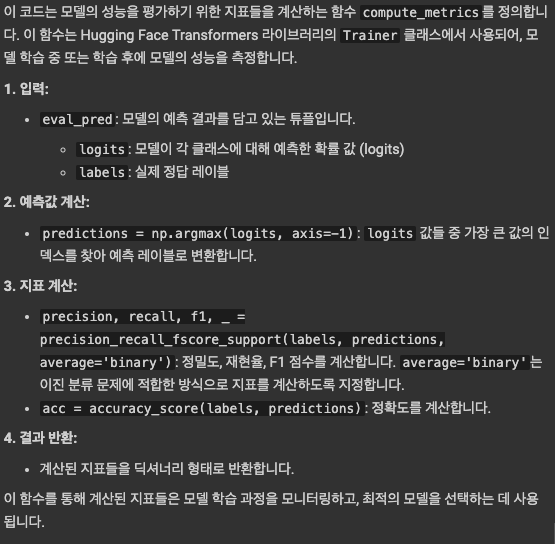

# Trainer 설정

In [31]:
os.environ["WANDB_PROJECT"]="HF_workshop"


wandb 계정이 있다면 셀 실행 / 없다면 패스

In [39]:
import wandb
wandb.login()

True

In [38]:
from google.colab import userdata
import wandb
# my api key on wandb can be found on wandb site
wandb_api_key = userdata.get('WANDB_API_KEY')
if wandb_api_key:
    wandb.login(key=wandb_api_key)
    print("Successfully logged in to Weights & Biases")
else:
    print("WANDB_API_KEY not found in Colab secrets")

wandb: Currently logged in as: qhdmswns (qhdmswns-hanyang-university). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to Weights & Biases


In [40]:

training_args = TrainingArguments(
    output_dir="./model-by-trainer",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1, # 전체 스텝의 10%는 웜업에 사용
    learning_rate=1e-4, # 학습률
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb", # wandb 계정이 없다면 "none" 으로 설정
    run_name="nsmc-text-classfication",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# 훈련

## Trainer 활용 훈련

참고: 샘플링하지 않고 전체 데이터 훈련시
- T4 에서는 에포크 당 25분 걸림
- RTX4090에서는 에포크 당 3분40초 걸림

In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.465300,0.393181,0.830000,0.837476,0.839080,0.835878
2,0.318500,0.423153,0.842000,0.845401,0.867470,0.824427
3,0.159000,0.480186,0.838000,0.843931,0.852140,0.835878


TrainOutput(global_step=72, training_loss=0.33613695328434307, metrics={'train_runtime': 57.1924, 'train_samples_per_second': 78.682, 'train_steps_per_second': 1.259, 'total_flos': 122247745830000.0, 'train_loss': 0.33613695328434307, 'epoch': 3.0})

## 커스텀 훈련 루프

In [42]:
# 메모리 해제 (완벽하게 해제되지는 않음)
del model
del trainer
torch.cuda.empty_cache()  # GPU 메모리 정리
gc.collect()  # 가비지 컬렉션 실행

1377

### 참고로 epoch , iteration 차이는 다음과 같다.  
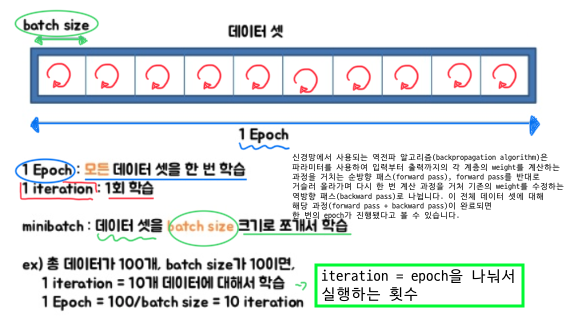

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, config=config)
# Hugging Face Transformers 라이브러리를 사용하여 model_id에 해당하는 사전 훈련된 모델을 불러옴.
# config에는 모델의 설정 정보 담겨있고, 이전에 정의한 레이블 정보 (id2label, label2id) 등이 포함.
model.to(device)# 말그대로 model to device(could be CPU or GPU)

compact_tokenized_datasets = tokenized_datasets.remove_columns(['id', 'document'])
#토큰화된 데이터셋에서 id와 document 컬럼을 제거 -> 훈련에 필요한 정보만 남김.

train_dataloader = DataLoader(compact_tokenized_datasets["train"], batch_size=32, shuffle=True, collate_fn=data_collator)
# 훈련 데이터셋을 배치 크기 32로 나누고, 셔플링하여 데이터 순서를 무작위로 섞습니다.
# collate_fn은 data_collator를 사용하여 각 배치를 모델 입력 형태로 변환합니다.
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# AdamW as an optimizer to update model's parameter. lr =  5e-5
num_epochs = 3 # model을 3번 전체 dataset에 대해 학습시킴
for epoch in range(num_epochs):
    model.train()
    for batch in tqdm(train_dataloader):
      # train_dataloader에서 배치 단위로 데이터를 가져와 학습합니다.(한번의 iteration)
      # tqdm은 진행 상황을 시각적으로 표시하는 라이브러리입니다.
        batch = {k: v.to(device) for k, v in batch.items()}
        # 배치 데이터를 device (GPU 또는 CPU)로 이동시킵니다.
        outputs = model(**batch)
        # 모델에 배치 데이터를 입력하고 출력을 계산합니다.
        loss = outputs.loss # output의 loss
        loss.backward()# 손실 값을 기반으로 모델 파라미터에 대한 기울기를 계산합니다.
        optimizer.step()#계산된 기울기를 사용하여 모델 파라미터를 업데이트합니다.
        optimizer.zero_grad()# 이전 배치에서 계산된 기울기를 초기화

    print(f"Epoch {epoch+1}/{num_epochs} completed")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/3 completed


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/3 completed


  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/3 completed


아 참고로 double asterisk는 이런 역할을 함  
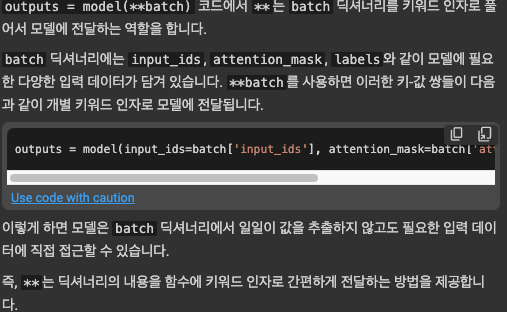

## 커스텀 훈련 검증 평가

In [44]:
model.eval()# model to evaluation mode -> dropout이나 batch norm같은 train focused layer를 deactivate
eval_dataloader = DataLoader(compact_tokenized_datasets["test"], batch_size=64, collate_fn=data_collator)
# 테스트 데이터셋을 배치 크기 64로 나누고, data_collator를 사용하여 모델 입력 형태로 변환

total_preds = []# 모델의 예측 결과를 저장할 리스트
total_labels = []# 실제 레이블을 저장할 리스트

with torch.no_grad():#기울기 계산을 비활성화하여 메모리 사용량을 줄이고 연산 속도를 높입니다.
    for batch in tqdm(eval_dataloader):#테스트 데이터 로더에서 배치 단위로 데이터를 가져옵니다.
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        #모델 출력에서 가장 높은 확률을 가진 클래스를 예측 결과로 선택합니다.
        total_preds.extend(preds.cpu().numpy())
        # 예측결과를 CPU로 이동하고, numpy배열로 변환하여 total_preds 리스트에 추가함
        total_labels.extend(batch["labels"].cpu().numpy())
        # 실제 label을 cpu로 이동하고 numpy배열로 변환하여 total_labels 리스트에 추가

accuracy = accuracy_score(total_labels, total_preds)
precision, recall, f1, _ = precision_recall_fscore_support(total_labels, total_preds, average='binary')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy: 0.818
F1 Score: 0.8383658969804617
Precision: 0.7840531561461794
Recall: 0.9007633587786259


Recall :  재현율 = TP / (TP + FN)  
Precision : 정밀도 = TP / (TP + FP)  
F1 점수 = 2 * (정밀도 * 재현율) / (정밀도 + 재현율)  
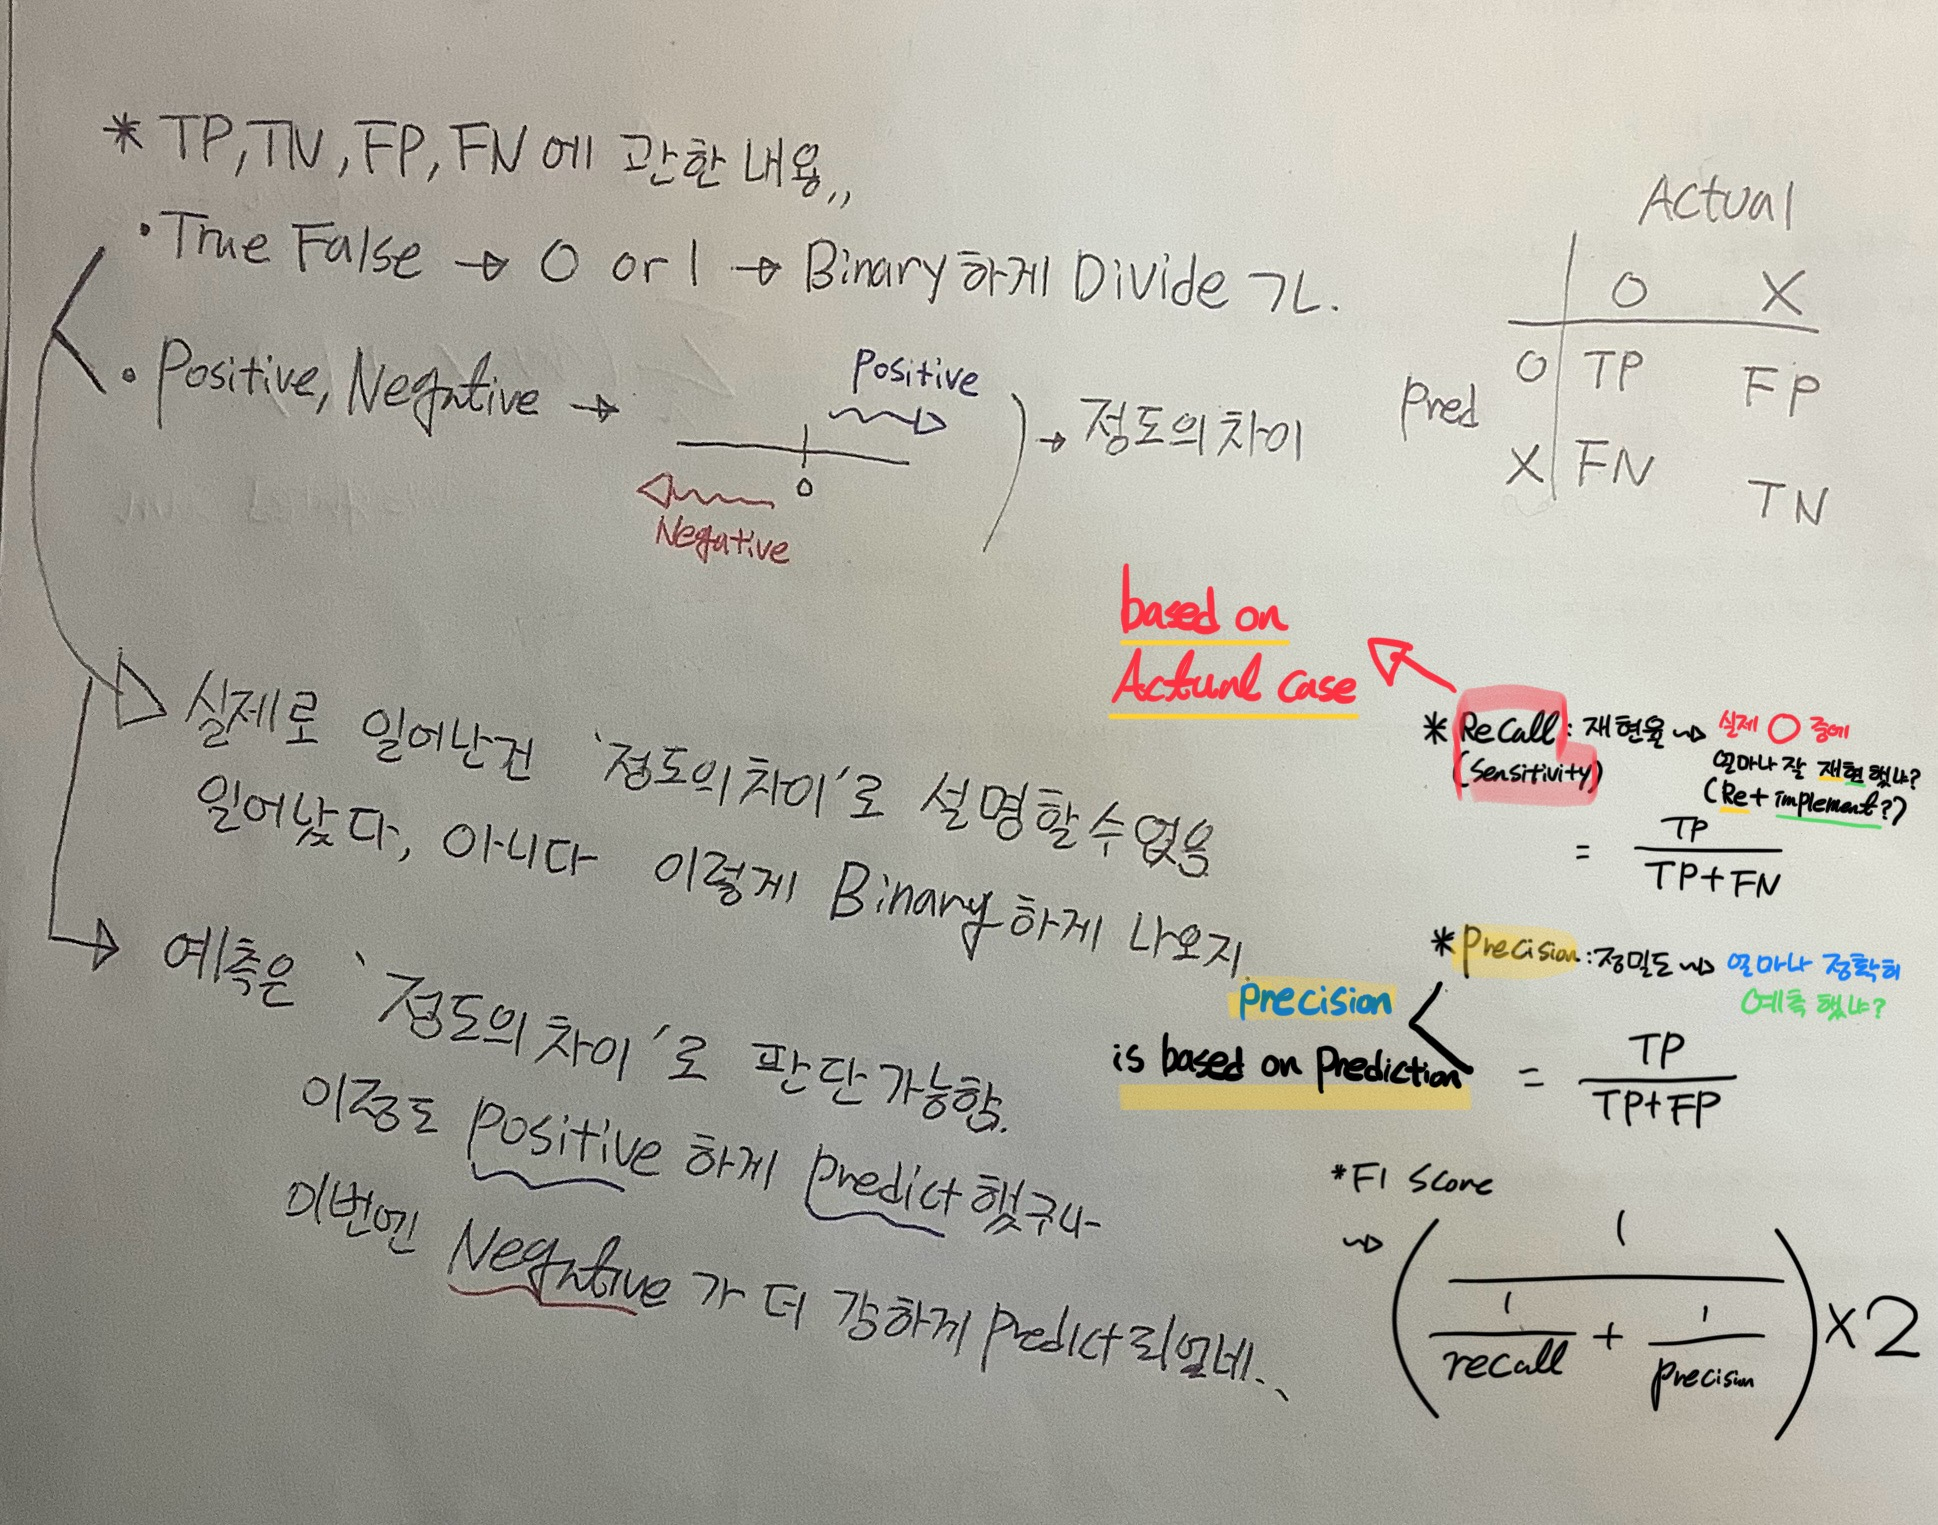


# 파이프라인을 통한 테스트

In [45]:
classification_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
# Hugging Face Transformers 라이브러리의 pipeline 함수를 사용하여 텍스트 분류 파이프라인을 생성하는 코드입니다.
# 이 파이프라인은 훈련된 모델 (model), 토크나이저 (tokenizer), 그리고 장치 (device)를 사용하여
# 텍스트를 입력받아 감성 (긍정 또는 부정)을 분류하는 작업을 수행합니다.
# 파이프라인을 생성하면 텍스트 분류 작업을 간편하게 수행할 수 있습니다.

# 예를 들어, 다음과 같이 파이프라인을 사용하여 텍스트의 감성을 예측할 수 있습니다.
# result = classification_pipeline("이 영화 정말 재밌어요!")
# print(result) -> [{'label':'긍정', 'score':0.993}]
# 씹 긍정으로 나옴
# pipeline은 text classification을 위한 preprocessing, model 추론, postprocessing 과정을
# 자동으로 처리해주기 때문에 사용자가 복잡한 코드를 생성하지 않아도쉽게 text classification 쓸 수 있도록
# 해준다링

In [52]:
classification_pipeline("저 착한것같지만 아닌거같기도 하고 등신같은 녀석.")
# 근데 문맥을 잘 고려하는거같진 않넹.. 애매하게 써도 긍부정 한쪽으로 쏠리는 느낌이 없잖아있음

[{'label': '부정', 'score': 0.9859572649002075}]

In [53]:
classification_pipeline("이 영화 정말 재밌어요!")

[{'label': '긍정', 'score': 0.9939770698547363}]